# 기본 설정

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위한 설정
np.random.seed(42)

# 깔끔한 그래프 출력을 위한 설정
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 3.1 MNIST

MNIST 데이터셋 내려받기

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

위 키 설명
* DESCR: 데이터셋을 설명하는 키
* data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 키
* target: 레이블 배열을 담은 키

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

위 결과를 보면 이미지가 70000개 있고 각 이미지에는 784개의 특성이 있음을 알 수 있음  

데이터셋에서 이미지 하나를 직접 확인해보기(아래)

그림 저장: some_digit_plot


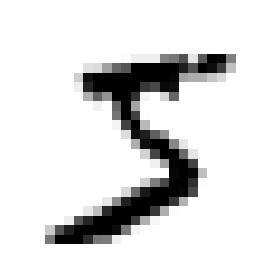

In [5]:
#%matplotlib inline
#import matplotlib as mpl
#import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

위 그림은 5처럼 보이는데 맞는지 실제 레이블을 확인(아래)

In [6]:
y[0]

'5'

위 레이블 형태를 보면 문자열 형태  
대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 모두 정수로 변환(아래)

In [7]:
y = y.astype(np.uint8)

MNIST 이미지 샘플을 더 확인해보기 위해 아래 코드를 추가하여 확인

In [8]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합침. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합침
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됨
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


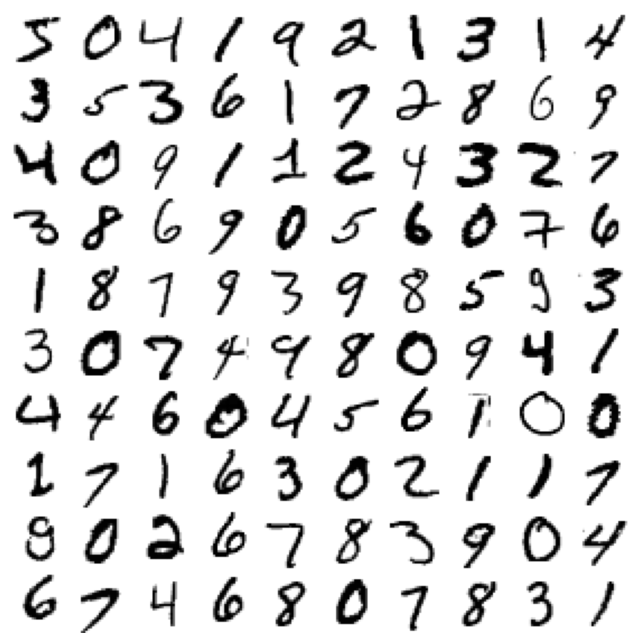

In [9]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

데이터를 자세히 조사하기 전에 훈련과 테스트 세트로 나누어 놓고 시작

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

문제를 단순화해서 숫자 5만 식별해보는 '5-감지기'를 만듦  
이 '5-감지기'는 '5'와 '5 아님' 2개의 클래스를 구분할 수 있는 **이진 분류기(binary classifier)**의 한 예  

분류 작업을 위해 타깃 벡터 생성(아래)

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

사이킷런의 **SGDClassifier** 클래스를 사용해 **확률적 경사 하강법(Stochastic Gradient Descent, SGD)** 분류기를 선택하여 훈련(아래)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

위 모델을 사용해 숫자 5의 이미지를 감지(아래)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

분류기가 이 이미지를 5라고 추측했음(True). 즉 이 경우 정확하게 맞췄다고 볼 수 있음  

이제 모델의 성능을 평가하는 단계로 넘어감

# 3.3 성능 측정

## 3.3.1 교차 검증을 사용한 정확도 측정

가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있음. 이때는 교차 검증 기능을 아래와 같이 직접 구현하면 됨  

**StratifiedKFold**는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


이번에는 **cross_val_score** 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 모델을 평가

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

위 결과를 보면 모든 교차 검증 폴드에 대해 **정확도(accuracy, 정확한 예측의 비율)**가 95% 이상임  

모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보겠음 

In [16]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

위 결과 역시 정확도가 모두 90% 이상으로 나왔음  
전체 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90% 정도라는 뜻  

이 MNIST 예제는 정확도(accuracy)를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌. 특히 **불균형한 데이터셋(ex. 어떤 클래스가 다른 것보다 월등히 많은 경우)**을 다룰 때 더욱 그러함

이럴 경우 **오차 행렬(confusion matrix)**을 조사하는 것이 분류기의 성능을 평가하는 더 좋은 방법임

## 3.3.2 오차 행렬

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함. 아래와 같이 **cross_val_predict()** 함수를 사용할 수 있음  

**cross_val_predict()** 함수는 **cross_val_score()** 함수처럼 k-겹 교차검증을 수행하지만, 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함. 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨(여기서 깨끗하다는 뜻은 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미)

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

이제 **confusion_matrix()** 함수를 사용해 오차 행렬을 만듦

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

위 결과를 아래 완벽한 분류기의 결과와 비교

In [20]:
# 완벽한 분류기 결과 예시
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

완벽한 분류기의 결과와 비교하여 confusion_matrix의 결과를 해석
* confusion matrix의 행: 실제 클래스
* confusion matrix의 열: 예측한 클래스  

<해석>
* 첫 번째 행: '5 아님' 이미지에 대한 것
    - 53892개를 '5 아님'으로 정확하게 분류(진짜 음성, True Negative)
    - 687개를 '5'로 잘못 분류(거짓 양성, False Positive)  


* 두 번째 행: '5' 이미지에 대한 것
    - 1891개를 '5 아님'으로 잘못 분류(거짓 음성, False Negative)
    - 3530개를 '5'로 정확하게 분류(진짜 양성, True Positive)  

완벽한 분류기라면 위 완벽한 분류기의 예시 결과처럼 confusion matrix의 주대각선(왼쪽 위에서 오른쪽 아래 방향)만 0이 아닌 값이 있고 나머진 0으로 차있어야 함

위 오차 행렬(confusion matrix)에서 꺼낼 수 있는 요약된 지표로는 크게 **정밀도(precision)**와 **재현율(recall)**이 있음

## 3.3.3 정밀도와 재현율

* 정밀도(precision): 양성으로 예측한 것 중 실제 양성의 비율
* 재현율(recall): 실제 양성 중 양성으로 예측한 것의 비율

우선 정밀도(precision)부터 확인

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

직접 정밀도를 계산하려면 아래처럼 짜면 됨

In [22]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

다음으로 재현율(recall) 확인

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

이 역시 직접 계산하려면 아래처럼 짜면 됨

In [24]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

위 수치들을 보면 '5-감지기'가 정확도를 살펴봤을 때만큼 성능이 좋아보이진 않음  
5로 예측한 이미지 중 실제 5는 83.7%, 실제 5 중 5로 예측한 비율은 65.1%에 불과함  

위 정밀도와 재현율을 **F1 점수(F1 score)**라는 하나의 숫자로 만들면 편리할 때가 많음  
**F1 점수(F1 score)**는 정밀도와 재현율의 조화 평균(harmonic mean)임  

이 역시 아래와 같이 **f1_score()** 함수로 계산 가능

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 점수를 직접 계산하려면 아래처럼 짜면 됨(조화 평균 계산 식)

In [26]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음  
그러나 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있기 때문에 **주어진 상황이 정밀도가 중요한 상황인지, 재현율이 중요한 상황인지 파악**하는 것이 매우 중요함  

## 3.3.4 정밀도/재현율 트레이드오프

<정밀도/재현율 트레이트오프>  
: 정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄어드는 안타까운 현상. 즉, 정밀도와 재현율 모두를 얻을 수는 없음

SGDClassifier 분류기는 **결정 함수(decision function)**를 사용하여 각 샘플의 점수를 계산하고, 이 점수가 **결정 임곗값(decision threshold)**보다 크면 샘플을 양성 클래스에 할당, 그렇지 않으면 음성 클래스에 할당함  

SGDClassifier 분류기의 **decision_function()** 메소드를 호출하면 각 샘플의 점수를 얻을 수 있음

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

위 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

임곗값이 0일 때는 **predict()** 메소드와 같은 결과(True)를 반환  
임곗값을 8000으로 높이면 아래와 같음

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

위 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여줌. 즉 이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8000으로 높이면 이를 놓치게 됨  

적절한 임곗값을 정하기 위해서는 먼저 **cross_val_predict()** 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함. 단, 이번에는 예측 결과가 아니라 **결정 점수**를 반환하도록 method를 지정해야 함

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

위 점수로 **precision_recall_curve()** 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있음(아래)

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

matplotlib을 이용해 임곗값의 함수로 정밀도와 재현율을 그리면 아래와 같음

그림 저장: precision_recall_vs_threshold_plot


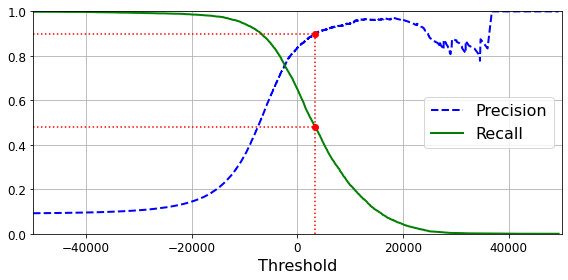

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 아래처럼 재현율에 대한 정밀도 곡선을 그리는 것임

그림 저장: precision_vs_recall_plot


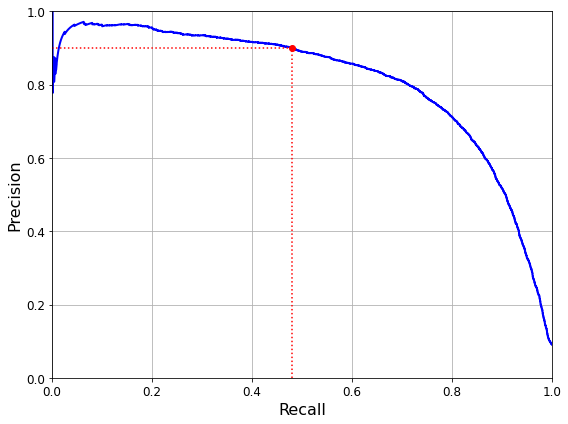

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

위 그래프를 보면 재현율이 80% 근처에서 정밀도가 급격하게 줄어들기 시작함. 이 하강점 직전, 예를 들어 재현율이 60% 정도인 지점을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음

정밀도 90%를 달성하는 것이 목표일 경우, 아래와 같이 코드를 작성하여 진행하면 됨

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

정밀도는 90%를 달성했지만 재현율이 약 48%로 재현율이 너무 낮기 때문에 이 분류기는 유용하지 않을 수 있음

## 3.3.5 ROC 곡선

<ROC(Receiver Operating Characteristic, 수신기 조작 특성) 곡선>  
**거짓 양성 비율(FPR, False Positive Rate)**에 대한 **진짜 양성 비율(TPR, True Positive Rate)**의 곡선  
민감도(재현율, TPR)에 대한 1-특이도(TNR) 그래프라고도 함

ROC 곡선을 그리려면 먼저 **roc_curve()** 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야 함

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그리고 나서 matplotlib을 사용해 TPR에 대한 FPR 곡선을 아래와 같이 나타낼 수 있음

그림 저장: roc_curve_plot


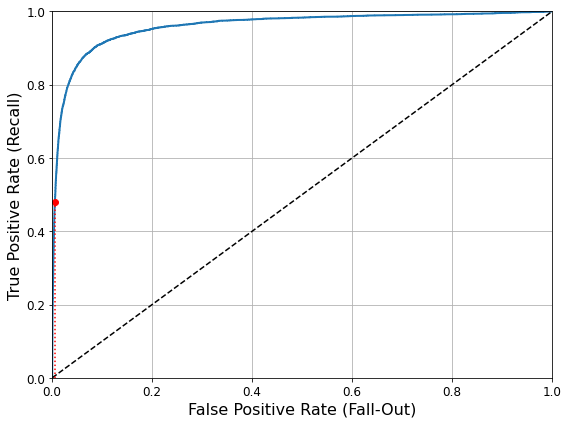

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선 삽입
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

위 그래프에서 붉은 점이 바로 선택한 비율(43.68%의 재현율)의 지점에 해당

여기에도 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다는 트레이드오프가 존재함  
위 그래프에서 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻하고, 좋은 분류기는 이 점선에서 최대한 왼쪽 위 모서리 쪽으로 멀리 떨어져 있어야 함

이때, **곡선 아래의 면적(AUC, Area Under the Curve)**을 측정하면 분류기들을 비교할 수 있음. 즉 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임  
사이킷런에서는 **roc_auc_score()**이라는 auc 계산 함수를 제공 

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교>  
먼저 훈련 세트의 샘플에 대한 점수를 얻어야 함
RandomForestClassifier에는 decision_function() 메소드가 없고 대신 **predict_proba()** 메소드가 있음

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

roc_curve() 함수는 레이블과 점수를 기대하지만, 점수 대신에 클래스 확률을 전달할 수 있음  
양성 클래스 확률을 점수로 사용하면 아래와 같음

In [42]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

비교를 위해 첫 번째 ROC 곡선도 함께 그리면 아래와 같음

그림 저장: roc_curve_comparison_plot


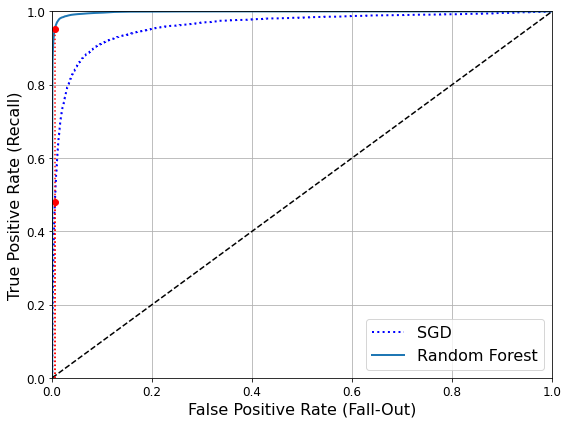

In [43]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

결과를 보면 RandomForest의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 AUC 값이 더 크기 때문에 RandomForest 분류기가 SGD 분류기보다 훨씬 좋다는 것을 알 수 있음

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [46]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

정밀도와 재현율도 각각 99%, 86.6%로 굉장히 높음을 확인 가능

# 3.4 다중 분류

이진 분류가 2개의 클래스를 구별하는 반면, **다중 분류기(multiclass classifier, 다항 분류기)**는 둘 이상의 클래스를 구별할 수 있음  

SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 같은 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면,  
로지스틱 회귀나 SVM 분류기 같은 알고리즘은 이진 분류만 가능. 이럴 경우 이진 분류기를 여러 개 이용해 다중 클래스를 분류하는 기법도 존재함

<이진 분류기를 여러 개 이용해 다중 클래스를 분류하는 기법들>
* OvR(One-versus-the-Rest) 전략: 특정 클래스 하나와 나머지 클래스 전부를 구분하는 방법
* OvO(One-versus-One) 전략: 각 클래스를 1:1로 구분하는 방법, N개의 클래스가 존재할 경우, 분류기는 Nx(N-1)/2개가 필요

우선 **sklearn.svm.SVC** 클래스를 사용해 서포트 벡터 머신 분류기를 테스트

In [47]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train임에 주의!
svm_clf.predict([some_digit])

array([5], dtype=uint8)

위 코느는 내부에서 사이킷런이 OvO 전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 가장 높은 클래스를 선택함  
정말 그런지 확인하기 위해 **decision_function()** 메소드를 호출하여 샘플당 10개의 점수를 반환(이 점수는 클래스마다 하나씩임)

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

가장 높은 점수가 클래스 5에 해당하는 값임

In [49]:
np.argmax(some_digit_scores)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 **OneVsOneClassifier**나 **OneVsRestClassifier**를 사용해야 함  
예를 들어 SVC 기반으로 OvR 전략을 사용하는 다중 분류기를 만들려면 아래와 같이 해야 함

In [52]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
len(ovr_clf.estimators_)

10

SGDClassifier(또는 RandomForestClassifier)를 훈련시키는 것도 간단(아래)

In [54]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없음  
**decision_function()** 메소드로 SGD 분류기가 클래스마다 부여한 점수를 확인

In [55]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**cross_val_score()** 함수를 사용해 SGDClassifier의 정확도를 평가하면 아래와 같음  

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# 3.5 에러 분석

이 절에서는 가능성이 높은 모델을 하나 찾았다고 가정하고, 이 모델의 성능을 향상시킬 방법을 찾아보겠음  
한 가지 방법은 **만들어진 에러의 종류를 분석하는 것**  

먼저 오차 행렬(confusion matrix) 살펴보기

In [57]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]],
      dtype=int64)

많은 숫자가 출력되어 눈에 잘 들어오지 않으므로 오차 행렬을 matplotlib의 matshow() 함수를 사용해 이미지로 표현하면 아래와 같음

그림 저장: confusion_matrix_plot


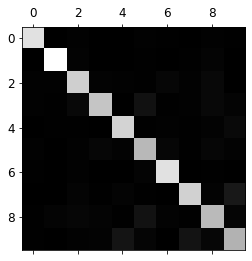

In [58]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

그래프의 에러 부분에 초점을 맞춰보겠음.  
먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러의 절대 개수가 아니라 에러 비율을 비교(개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보이기 때문)

In [59]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 다시 그림

그림 저장: confusion_matrix_errors_plot


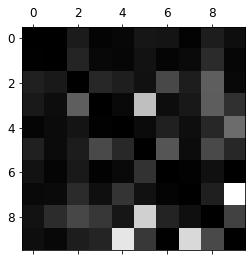

In [60]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

위 그래프를 통해 분류기가 만든 에러를 확실히 볼 수 있음.  
행은 실제 클래스, 열은 예측한 클래스를 나타낸다는 것을 바탕으로 생각하면 밝은 부분에 해당하는 부분(3과 8을 5로 잘못 분류한 경우, 9를 4 또는 7로 잘못 분류한 경우, 7을 9로 잘못 분류한 경우)이 높은 에러에 해당한다는 것을 알 수 있음  

뿐만 아니라 위 그래프에서 볼 수 있듯이 오차 행렬은 반드시 대칭인 것은 아니라는 점도 확인할 수 있고, 특히 7과 9가 많이 혼동되고 있는 것을 볼 수 있음

7과 9에 대하여 이미지를 따로 살펴보면 아래와 같음

그림 저장: error_analysis_digits_plot


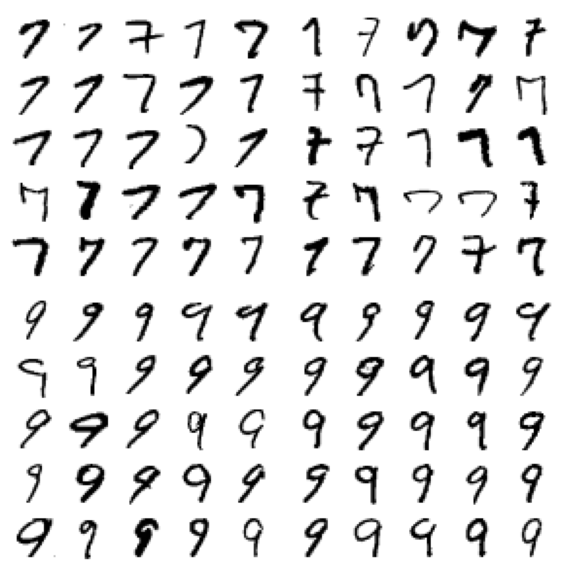

In [61]:
cl_a, cl_b = 7, 9
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

위 모습을 보면 확실히 7과 9를 혼동할 만 하다고 판단할 수 있음

# 3.6 다중 레이블 분류

여러 개의 이진 꼬리표를 출력하는 분류 시스템을 **다중 레이블 분류(multilabel classification)** 시스템이라고 함

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

위 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 **y_multilabel** 배열을 만듦  
첫 번째는 숫자가 큰 값(7,8,9)인지 나타내고 두 번째는 홀수인지 나타냄  
그 다음 줄이 KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킴  

이제 예측을 만들면 아래와 같이 레이블이 두 개 출력됨

In [63]:
knn_clf.predict([some_digit])

array([[False,  True]])

숫자 5는 크지 않고(False) 홀수(True)이므로 올바르게 분류되었음을 알 수 있음

다중 레이블 분류기를 평가하는 방법 중에는 아래 코드처럼 모든 레이블에 대한 F1 점수의 평균을 계산하는 방법이 있음  

In [64]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 3.7 다중 출력 분류

**다중 출력 분류(multioutput classification)**는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것  

먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 **randint()** 함수를 사용하여 픽셀 강도에 잡음을 추가하겠음. 타겟 이미지는 원본 이미지를 가리킴

In [65]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

테스트 세트에서 이미지를 하나 선택

In [66]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

그림 저장: noisy_digit_example_plot


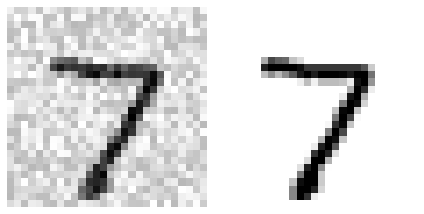

In [67]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

왼쪽이 잡음이 섞인 이미지이고 오른쪽이 깨끗한 타깃 이미지  
분류기를 훈련시켜 이 이미지를 깨끗하게 만들면 아래처럼 됨

그림 저장: cleaned_digit_example_plot


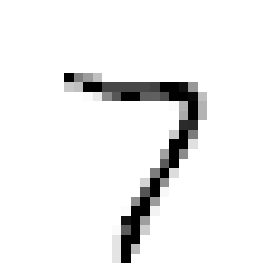

In [68]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

결과를 보면 오른쪽 타깃과 매우 비슷해졌음을 알 수 있음

# END